# Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

# Load Data

In [5]:
df = pd.read_csv("insurance.csv")

In [6]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


In [7]:
df['smoker_binary'] = (df['smoker'] == 'yes').astype(int)
df['smoker_age'] = df['smoker_binary'] * df['age']
df['smoker_bmi'] = df['smoker_binary'] * df['bmi']
df = df.drop('smoker_binary', axis=1)

# Transforming Output Feature

In [8]:
X = df.drop('charges', axis=1)
y = df['charges']

# Apply log transformation to target variable
y_log = np.log(y)

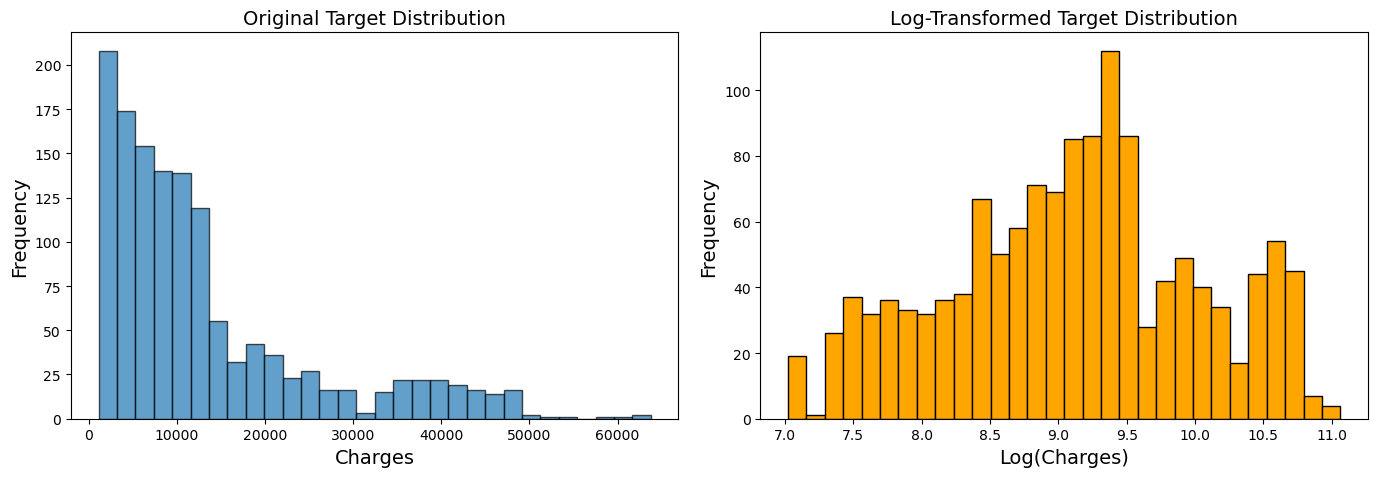

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Charges')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Original Target Distribution')

axes[1].hist(y_log, bins=30, edgecolor='black', color='orange')
axes[1].set_xlabel('Log(Charges)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Target Distribution')

plt.tight_layout()
plt.show()

# Split Dataset

In [10]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [11]:
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1070
Test set size: 268


# Creating Pipeline

In [12]:
numerical_cols = ['age', 'bmi', 'children', 'smoker_age', 'smoker_bmi']
categorical_cols = ['sex', 'smoker', 'region']

In [13]:
def create_preprocessing_pipeline(polynomial_degree=1):
    numerical_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=polynomial_degree, include_bias=False))
    ])

    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])
    
    return preprocessor

In [14]:
def create_full_pipeline(model, polynomial_degree=1):
    preprocessor = create_preprocessing_pipeline(polynomial_degree)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    return pipeline

In [15]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import uniform, loguniform

In [16]:
# Ridge Regression
ridge_param_dist = {
    'preprocessor__num__poly__degree': [1, 2, 3],
    'model__alpha': loguniform(1e-3, 1e3),
    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

# Lasso Regression
lasso_param_dist = {
    'preprocessor__num__poly__degree': [1, 2, 3],
    'model__alpha': loguniform(1e-3, 1e3),
    'model__max_iter': [10000, 20000, 50000]
}

# ElasticNet Regression
elasticnet_param_dist = {
    'preprocessor__num__poly__degree': [1, 2, 3],
    'model__alpha': loguniform(1e-3, 1e3),
    'model__l1_ratio': uniform(0, 1),  # Mix between L1 and L2
    'model__max_iter': [10000, 20000, 50000]
}

In [17]:
results = {}

models = {
    'Ridge': (Ridge(random_state=42), ridge_param_dist),
    'Lasso': (Lasso(random_state=42), lasso_param_dist),
    'ElasticNet': (ElasticNet(random_state=42), elasticnet_param_dist)
}

In [18]:
# Perform RandomizedSearchCV for each model
print("Starting hyperparameter tuning...\n")

for model_name, (model, param_dist) in models.items():
    print(f"\n{'='*60}")
    print(f"Tuning {model_name}...")
    print(f"{'='*60}")

    # Create pipeline
    pipeline = create_full_pipeline(model)

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=100,  # Number of parameter settings sampled
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1,  # Use all processors
        random_state=42,
        verbose=1
    )

    # Fit the model
    random_search.fit(X_train, y_train_log)

    # Store results
    results[model_name] = {
        'best_estimator': random_search.best_estimator_,
        'best_params': random_search.best_params_,
        'best_cv_score': -random_search.best_score_,  # Convert back to positive MSE
        'cv_results': random_search.cv_results_
    }

    print(f"\nBest parameters for {model_name}:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best CV MSE: {-random_search.best_score_:.4f}")
    print(f"Best CV RMSE: {np.sqrt(-random_search.best_score_):.4f}")

Starting hyperparameter tuning...


Tuning Ridge...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters for Ridge:
  model__alpha: 5.068612120448909
  model__solver: svd
  preprocessor__num__poly__degree: 2
Best CV MSE: 0.1444
Best CV RMSE: 0.3799

Tuning Lasso...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters for Lasso:
  model__alpha: 0.002231010801867922
  model__max_iter: 10000
  preprocessor__num__poly__degree: 3
Best CV MSE: 0.1440
Best CV RMSE: 0.3795

Tuning ElasticNet...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters for ElasticNet:
  model__alpha: 0.005260025951343321
  model__l1_ratio: 0.3418796667164016
  model__max_iter: 10000
  preprocessor__num__poly__degree: 3
Best CV MSE: 0.1441
Best CV RMSE: 0.3796


# Comparing Results

In [19]:
# Evaluate each model on the test set
evaluation_results = []

for model_name, model_info in results.items():
    best_model = model_info['best_estimator']
    
    # Predictions on log scale
    y_pred_log = best_model.predict(X_test)
    
    # Convert predictions back to original scale
    y_pred = np.exp(y_pred_log)  # expm1 is inverse of log1p
    y_test_original = np.exp(y_test_log)
    
    # Calculate metrics on original scale
    mse_orig = mean_squared_error(y_test_original, y_pred)
    rmse_orig = np.sqrt(mse_orig)
    mae_orig = mean_absolute_error(y_test_original, y_pred)
    r2_orig = r2_score(y_test_original, y_pred)
    
    evaluation_results.append({
        'Model': model_name,
        'RMSE': rmse_orig,
        'MAE': mae_orig,
        'R²': r2_orig,
        'Polynomial Degree': model_info['best_params']['preprocessor__num__poly__degree']
    })

# Create DataFrame for easy comparison
eval_df = pd.DataFrame(evaluation_results)
eval_df = eval_df.round(4)
eval_df

,Model,RMSE,MAE,R²,Polynomial Degree
0,Ridge,4477.3385,2263.5005,0.8709,2
1,Lasso,4626.1486,2308.8271,0.8621,3
2,ElasticNet,4641.5919,2316.4321,0.8612,3


In [23]:
print("\nBest Hyperparameters:")

for model_name, model_info in results.items():
    print(f"\n{model_name}:")
    for param, value in model_info['best_params'].items():
        print(f"  {param}: {value}")


Best Hyperparameters:

Ridge:
  model__alpha: 5.068612120448909
  model__solver: svd
  preprocessor__num__poly__degree: 2

Lasso:
  model__alpha: 0.002231010801867922
  model__max_iter: 10000
  preprocessor__num__poly__degree: 3

ElasticNet:
  model__alpha: 0.005260025951343321
  model__l1_ratio: 0.3418796667164016
  model__max_iter: 10000
  preprocessor__num__poly__degree: 3


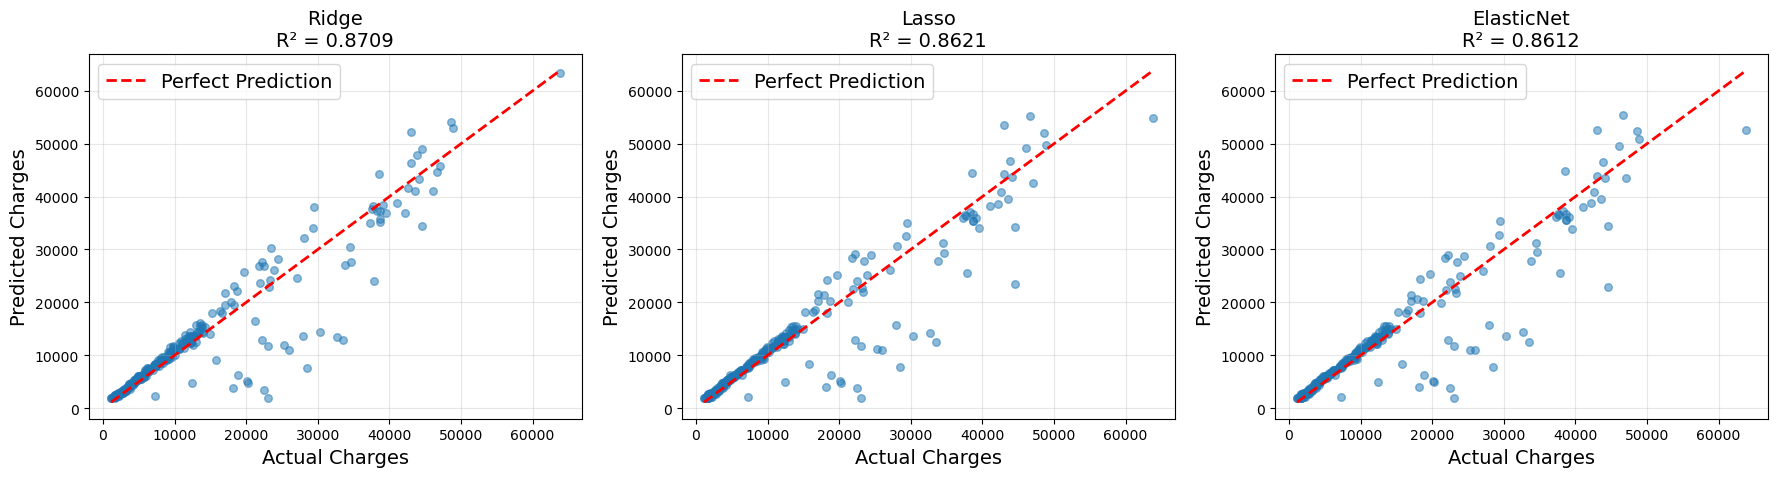

In [24]:
# Predicted vs Actual plots for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, model_info) in enumerate(results.items()):
    best_model = model_info['best_estimator']
    
    # Predictions
    y_pred_log = best_model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_test_original = np.exp(y_test_log)
    
    # Plot
    axes[idx].scatter(y_test_original, y_pred, alpha=0.5, s=30)
    axes[idx].plot([y_test_original.min(), y_test_original.max()], 
                   [y_test_original.min(), y_test_original.max()], 
                   'r--', lw=2, label='Perfect Prediction')
    axes[idx].set_xlabel('Actual Charges')
    axes[idx].set_ylabel('Predicted Charges')
    axes[idx].set_title(f'{model_name}\nR² = {eval_df.loc[idx, "R²"]:.4f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Findings

* Previously, we only used raw features. Here, I added smoker interaction features that can capture the multiplicative effect of smoking on `age` and `bmi`, which is critical for insurance charges.
* This exercise shows how feature engineering and mathematical transformations can dramatically improve predictive performance. The best model in EX6 (Ridge Regression with polynomial features) achieved an RMSE of 4,477.34 compared to the original baseline of 5,796.28 (22.7% improvement). The $R^2$ score also increased from 0.784 to 0.871.
* Another improvement came from applying a logarithmic transformation to the heavily right-skewed target variable (`charges`). By transforming the target before training and converting predictions back to the original scale, the model could better handle the wide range of medical costs.
* I also explored Ridge, Lasso, and ElasticNet regression with polynomial feature expansion. The best performing  model (Ridge) used 2-degree polynomials, introducing quadratic terms that capture more sophisticated relationships. The regularization ($\alpha$=5.07) prevented overfitting despite the increased feature complexity.
* I also used RandomizedSearchCV with 100 iterations and 5-fold cross-validation, systematically exploring the hyperparameter space for the models. This approach revealed that different regularization methods prefer different polynomial degrees. Ridge performed best with degree-2, while Lasso and ElasticNet preferred degree-3. This finding highlights that hyperparameter tuning isn't just about finding the "best" setting in isolation, but understanding how different components interact.